<h2> Imports </h2>

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [6]:
pip install pennylane-qiskit

  Using cached PennyLane_qiskit-0.15.0-py3-none-any.whl (21 kB)
  Using cached PennyLane-0.15.0-py3-none-any.whl (454 kB)
  Using cached semantic_version-2.6.0-py3-none-any.whl (14 kB)
  Using cached autograd-1.3-py3-none-any.whl


  Using cached future-0.18.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


<h3> Loading the Breast Cancer Dataset </h3>
<h4> This dataset is the same as the one provided by Scikit Learn Library </h4>

In [30]:
"""
breast cancer dataset
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit.aqua import MissingOptionalLibraryError


def breast_cancer(training_size, test_size, n, plot_data=False):
    """ returns breast cancer dataset """
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(return_X_y=True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError as ex:
            raise MissingOptionalLibraryError(
                libname='Matplotlib',
                name='breast_cancer',
                pip_install='pip install matplotlib') from ex
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train
#training_input, test_input, class_labels

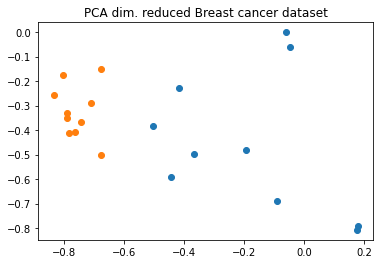

[[-0.80381589 -0.17496736  0.02153529 -0.07187231 -0.1397565 ]
 [-0.19172231 -0.48047638 -0.5502895   0.62866253 -0.02604959]
 [-0.8333448  -0.25876499 -0.26384514  0.1756967  -0.32234254]
 ...
 [-0.88227162 -0.50950835 -0.48471936  0.09871863  0.06051423]
 [-0.36471423 -0.4851768  -0.58003495  0.09196946 -0.00202821]
 [-0.81134279 -0.25945047 -0.54472716 -0.13189968 -0.06312866]]


In [31]:
print(breast_cancer(10,10,5,True))

<h3> Defining my own array of pixels (with random values) </h3>
<h4> Used for simulation/demonstration of code </h4>

<h4> [-1, 2, 4, 8] </h4>
<h4> [-2, 6, 4, 3] </h4>
<h4> [0, 10, 1, 2] </h4>
<h4> [1, 18, 9, 6] </h4>

In [33]:
from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2, 4, 8], [-2, 6, 4, 3], [0, 10, 1, 2], [1, 18, 9, 6]]
scaler = MinMaxScaler()
scaler.fit(data)
scaledData = scaler.transform(data)

#print(scaler.data_max_)
#print(scaler.transform(data))
#print(scaler.transform([[2, 2]]))

In [34]:
scaledData = scaledData.tolist()
print(scaledData)

[[0.3333333333333333, 0.0, 0.375, 1.0], [0.0, 0.25, 0.375, 0.16666666666666669], [0.6666666666666666, 0.5, 0.0, 0.0], [1.0, 1.0, 1.0, 0.6666666666666667]]


In [35]:
oneDimVec = []
for i in range(4):
    for j in range(4):
        oneDimVec.append(scaledData[i][j])
oneDimVec

[0.3333333333333333,
 0.0,
 0.375,
 1.0,
 0.0,
 0.25,
 0.375,
 0.16666666666666669,
 0.6666666666666666,
 0.5,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.6666666666666667]

<h3> Amplitude Encoding done via Pennylane Package and Template </h3>

In [36]:
import pennylane as qml
from pennylane.templates import AmplitudeEmbedding

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2), normalize=True)
    return qml.expval(qml.PauliZ(0))

In [37]:
def oneDimVecConverter(thisList):
    encoded = []
    for i in range(5,len(thisList)):
        top = thisList[i-5:i-5+2]
        bottom = thisList[i-2:i]
        window = top + bottom
        #print(newList)
        encoded.append(circuit(f=window))
    return encoded

In [38]:
oneDimVecConverter(oneDimVec)

[tensor(-0.8, requires_grad=True),
 tensor(0.38461538, requires_grad=True),
 tensor(0.69767442, requires_grad=True),
 tensor(0.71173848, requires_grad=True),
 tensor(-0.76623377, requires_grad=True),
 tensor(-0.54738878, requires_grad=True),
 tensor(-0.19502075, requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(-0.18032787, requires_grad=True),
 tensor(-0.77777778, requires_grad=True),
 tensor(-1., requires_grad=True)]

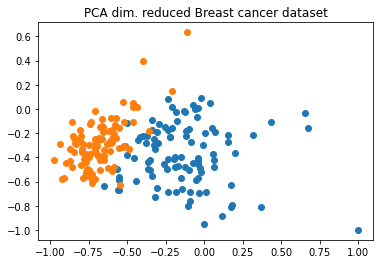

[[-0.80381589 -0.17496736  0.02153529 -0.07187231]
 [-0.19172231 -0.48047638 -0.5502895   0.62866253]
 [-0.8333448  -0.25876499 -0.26384514  0.1756967 ]
 ...
 [-0.88227162 -0.50950835 -0.48471936  0.09871863]
 [-0.36471423 -0.4851768  -0.58003495  0.09196946]
 [-0.81134279 -0.25945047 -0.54472716 -0.13189968]]


In [56]:
#breast_cancer(training_size, test_size, n, plot_data=False)
print(breast_cancer(100,10,4,True))

In [64]:
listss = breast_cancer(1,0,4,False)
listss

array([[-0.80381589, -0.17496736,  0.02153529, -0.07187231],
       [-0.19172231, -0.48047638, -0.5502895 ,  0.62866253],
       [-0.8333448 , -0.25876499, -0.26384514,  0.1756967 ],
       ...,
       [-0.88227162, -0.50950835, -0.48471936,  0.09871863],
       [-0.36471423, -0.4851768 , -0.58003495,  0.09196946],
       [-0.81134279, -0.25945047, -0.54472716, -0.13189968]])

In [65]:
listssss = []
for i in range(len(listss)):
    for j in range(4):
        listssss.append(listss[i][j])
listssss

[-0.8038158858872994,
 -0.17496736382219552,
 0.021535285137878724,
 -0.07187230768582797,
 -0.19172231366444975,
 -0.4804763805188046,
 -0.5502894962335217,
 0.6286625252004339,
 -0.8333447971642738,
 -0.2587649915443251,
 -0.2638451393394332,
 0.17569669597306958,
 -0.707308042371696,
 -0.29054462779799384,
 -0.44993422878478223,
 0.03257196824515646,
 -0.7900876243261654,
 -0.33130850015937774,
 -0.2835391588055476,
 0.19137684423642462,
 -0.08931674925631095,
 -0.6904727597364662,
 -0.344734738076843,
 0.24309069613655848,
 -0.6759968569780903,
 -0.5028222199263991,
 -0.4108229774939701,
 0.054092685810258945,
 -0.6754742505055664,
 -0.15140441091169773,
 -0.5247783190437075,
 0.020623384315980986,
 -0.7904197918643627,
 -0.35227700021620634,
 -0.3997834692320944,
 0.24391653590017698,
 -0.7815055446333297,
 -0.4135357079291375,
 -0.48452890936749177,
 -0.05467578728604816,
 -0.7621208437908469,
 -0.40881569326714584,
 -0.4804050430025151,
 0.10812650073419286,
 -0.7430480294328703

In [66]:
new = []
for i in range(5,len(listssss)):
    a = listssss[i-5:i-5+2]
    b = listssss[i-2:i]
    newList = a + b
    #print(newList)
    new.append(circuit(f=newList))

In [67]:
len(new)

1587

In [68]:
len(new)

base = []
for i in range(len(new)):
    base.append(i)
#base

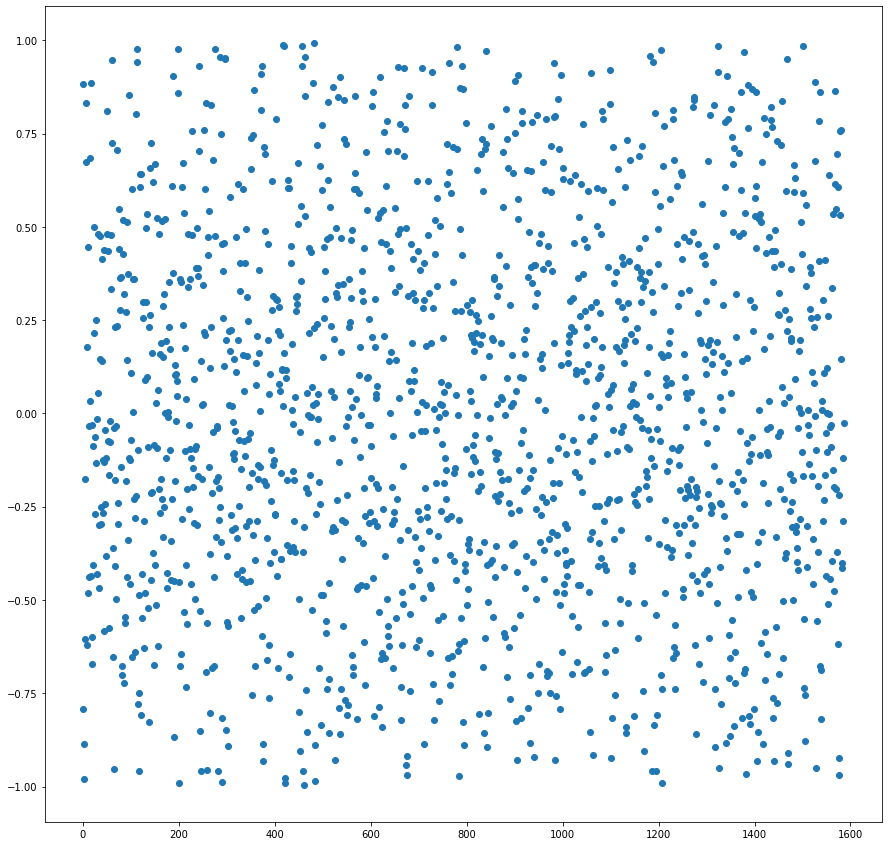

In [69]:
#for k in range(0, 2):
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.scatter(base,new)
plt.show()